In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
from arviz.plots.plot_utils import xarray_var_iter
import theano
import theano.tensor as tt
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

%matplotlib inline

RANDOM_SEED = 42

In [3]:
stockx_data = pd.read_csv('StockX-Data-Contest-2019-3.csv')

In [4]:
#Seeing how many rows/columns we're working with
print(stockx_data.shape)

(99956, 8)


In [5]:
#Getting first glimpse at dataset
stockx_data.head(10)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island
5,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$798,$220,2/11/17,8.5,Michigan
6,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-White,$784,$220,12/17/16,11.0,California
7,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$460,$220,4/29/17,10.0,New York
8,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$465,$220,4/29/17,11.0,Kansas
9,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$465,$220,4/29/17,11.0,Florida


In [6]:
stockx_data.isna().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

In [7]:
stockx_data.dtypes

Order Date       object
Brand            object
Sneaker Name     object
Sale Price       object
Retail Price     object
Release Date     object
Shoe Size       float64
Buyer Region     object
dtype: object

In [8]:
def cleanCurrency(series):
    """
    Input: a dataframe series for currency (USD)
    Output: cleaned series as a float
    """
    #Replaces dollar sign and comma with empty string
    series = series.str.replace('$', '', regex=True)
    series = series.str.replace(',', '', regex=True)
    series = series.astype(float)
    return series

In [9]:
#Fix the Price fields to only be numeric
stockx_data['Sale Price'] = cleanCurrency(stockx_data['Sale Price'])
stockx_data['Retail Price'] = cleanCurrency(stockx_data['Retail Price'])

#Calculate Profit by subtracting Sale from Retail
stockx_data['Profit'] = stockx_data['Sale Price'] - stockx_data['Retail Price']

In [10]:
#Cleaning Sneaker Name column by removing hyphens
stockx_data['Sneaker Name'] = stockx_data['Sneaker Name'].str.replace('-', '')

#Making brand name a little more descriptive
stockx_data['Brand'] = stockx_data['Brand'].str.replace('Yeezy', 'Yeezy (Adidas)')
stockx_data['Brand'] = stockx_data['Brand'].str.replace('Off-White', 'Off-White (Nike)')

#Getting only 'object' dtype columns and then stripping trailing white spaces
stockx_data_obj = stockx_data.select_dtypes(['object'])
stockx_data[stockx_data_obj.columns] = stockx_data_obj.apply(lambda x: x.str.strip())

In [11]:
#Ensure date fields are the right dtype
stockx_data['Order Date'] = pd.to_datetime(stockx_data['Order Date'])
stockx_data['Release Date'] = pd.to_datetime(stockx_data['Release Date'])

#Calculate Duration of Days from Release Date to Order Date
stockx_data['Duration (days)'] = stockx_data['Order Date'] - stockx_data['Release Date']

In [12]:
#Univariate stats on the numeric measures
stockx_data.describe()

,Sale Price,Retail Price,Shoe Size,Profit,Duration (days)
count,99956.000000,99956.00000,99956.000000,99956.000000,99956
mean,446.634719,208.61359,9.344181,238.021129,183 days 17:00:33.566769376
std,255.982969,25.20001,2.329588,266.133179,232 days 08:29:57.865283340
min,186.000000,130.00000,3.500000,-34.000000,-69 days +00:00:00
25%,275.000000,220.00000,8.000000,58.000000,10 days 00:00:00
50%,370.000000,220.00000,9.500000,154.000000,56 days 00:00:00
75%,540.000000,220.00000,11.000000,342.000000,345 days 00:00:00
max,4050.000000,250.00000,17.000000,3860.000000,1321 days 00:00:00


In [13]:
print(stockx_data['Order Date'].min(), stockx_data['Order Date'].max())

2017-09-01 00:00:00 2019-02-13 00:00:00


In [14]:
transformer = PowerTransformer()

stockx_data['Profit_transformed'] = transformer.fit_transform(stockx_data['Profit'].values.reshape(-1, 1))

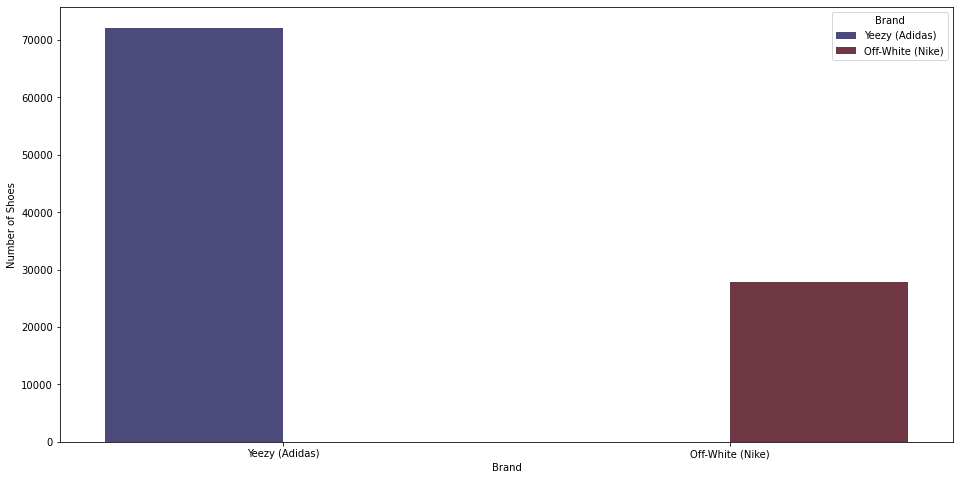

In [15]:
#Grouping by Brand to see how the general distribution of sales are
brand_group = pd.DataFrame(stockx_data.groupby('Brand').size(), columns=['values']).reset_index().sort_values('values', ascending=False)
brand_group['values'] = brand_group['values'].astype(int)
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=brand_group['Brand'], y=brand_group['values'], data=brand_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.show()

In [16]:
# plt.figure(figsize=(16, 8))
# plt.rcParams.update({'font.size': 10})
# ax = sns.boxplot(x=brand_group['Brand'], y=brand_group['values'], data=brand_group, hue=['Brand'], palette="icefire")
# ax.set(ylabel='Number of Shoes')
# plt.show()

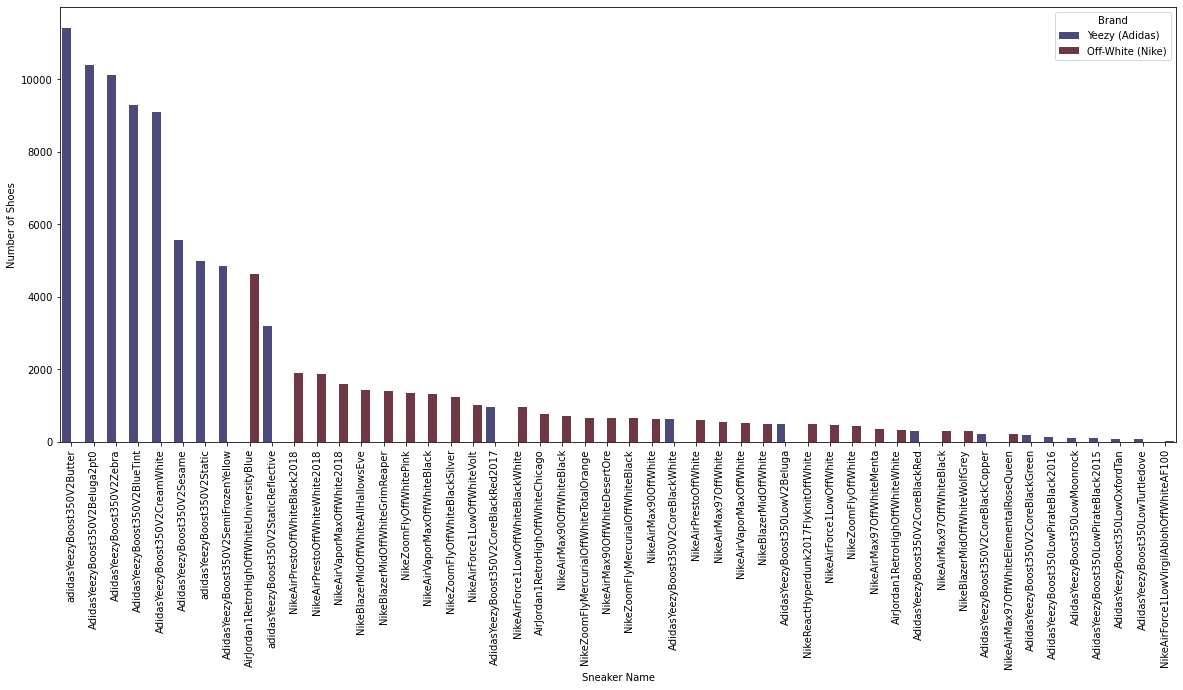

In [17]:
#Grouping by Sneaker Name to see how the general distribution of ratings are
sneaker_group = pd.DataFrame(stockx_data.groupby(['Brand', 'Sneaker Name']).size(), columns=['values']).reset_index().sort_values('values', ascending=False)
sneaker_group['values'] = sneaker_group['values'].astype(int)
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=sneaker_group['Sneaker Name'], y=sneaker_group['values'], data=sneaker_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.xticks(rotation=90)
plt.show()

In [18]:
sneaker_group[:10]

,Brand,Sneaker Name,values
47,Yeezy (Adidas),adidasYeezyBoost350V2Butter,11423
36,Yeezy (Adidas),AdidasYeezyBoost350V2Beluga2pt0,10395
46,Yeezy (Adidas),AdidasYeezyBoost350V2Zebra,10110
37,Yeezy (Adidas),AdidasYeezyBoost350V2BlueTint,9297
43,Yeezy (Adidas),AdidasYeezyBoost350V2CreamWhite,9097
45,Yeezy (Adidas),AdidasYeezyBoost350V2Sesame,5553
48,Yeezy (Adidas),adidasYeezyBoost350V2Static,4983
44,Yeezy (Adidas),AdidasYeezyBoost350V2SemiFrozenYellow,4854
1,Off-White (Nike),AirJordan1RetroHighOffWhiteUniversityBlue,4635
49,Yeezy (Adidas),adidasYeezyBoost350V2StaticReflective,3184


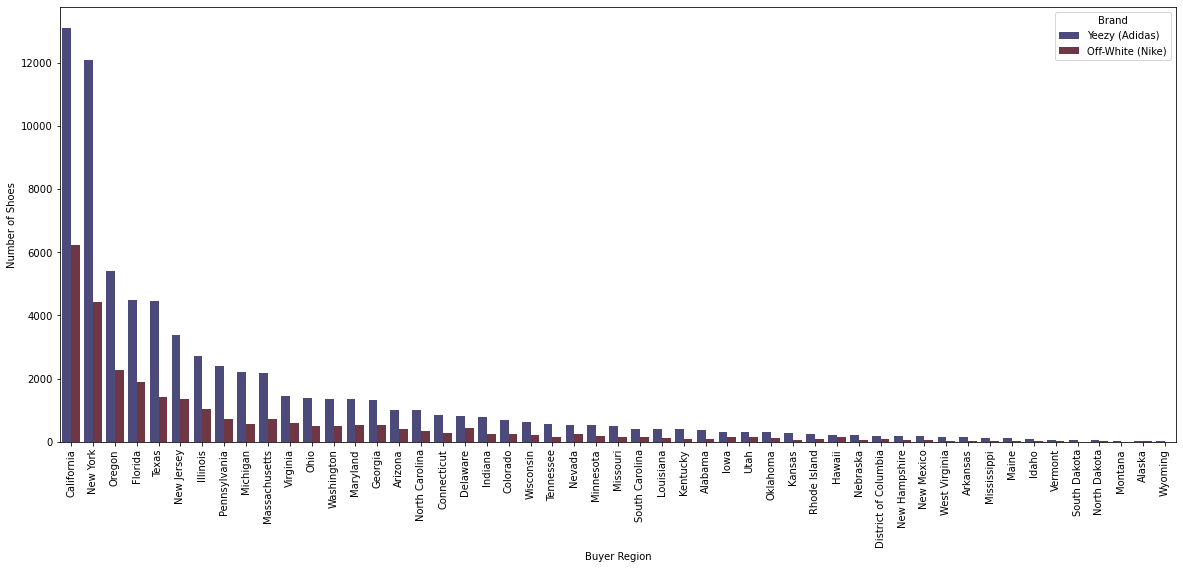

In [19]:
#Grouping by Region to see how the general distribution of ratings are
region_group = pd.DataFrame(stockx_data.groupby(['Buyer Region', 'Brand']).size(), columns=['values']).reset_index().sort_values(by='values', ascending=False)
region_group['values'] = region_group['values'].astype(int)
plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 10})
ax = sns.barplot(x=region_group['Buyer Region'], y=region_group['values'], data=region_group, hue='Brand', palette="icefire")
ax.set(ylabel='Number of Shoes')
plt.xticks(rotation=90)
plt.show()

In [20]:
region_group[:10]

,Buyer Region,Brand,values
9,California,Yeezy (Adidas),13113
65,New York,Yeezy (Adidas),12103
8,California,Off-White (Nike),6236
75,Oregon,Yeezy (Adidas),5396
19,Florida,Yeezy (Adidas),4484
87,Texas,Yeezy (Adidas),4455
64,New York,Off-White (Nike),4422
61,New Jersey,Yeezy (Adidas),3371
27,Illinois,Yeezy (Adidas),2732
77,Pennsylvania,Yeezy (Adidas),2396


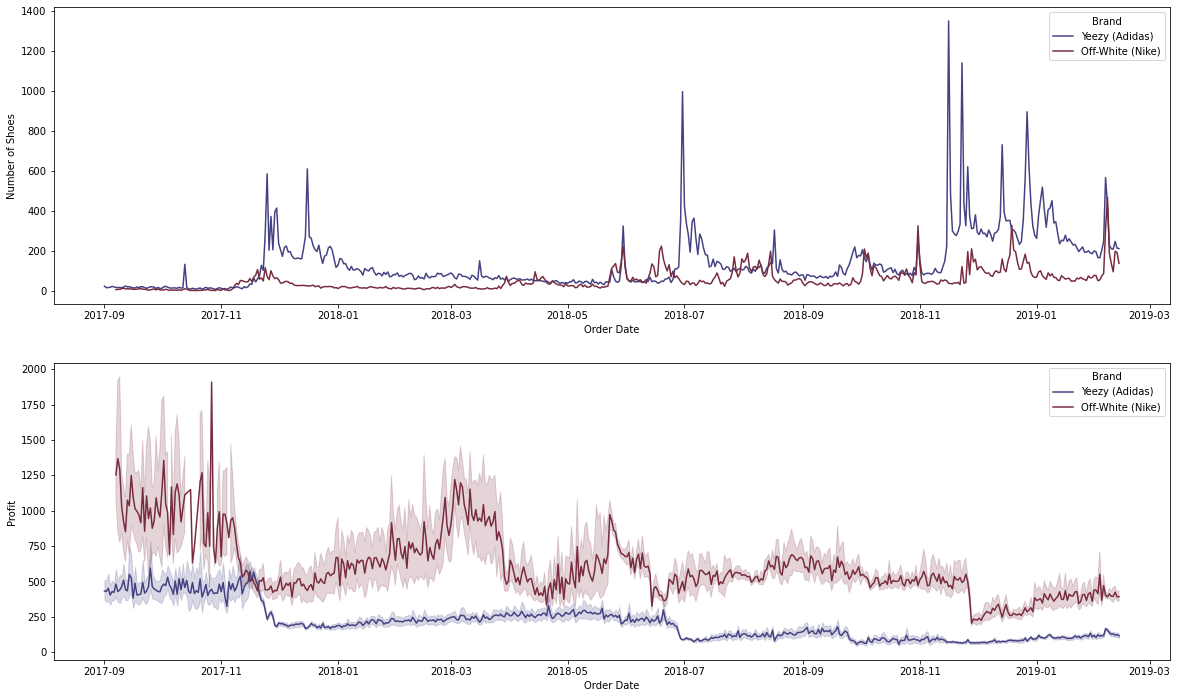

In [21]:
order_group = pd.DataFrame(stockx_data.groupby(['Order Date', 'Brand']).size(), columns=['values']).reset_index().sort_values(by='values', ascending=False)
order_group['values'] = order_group['values'].astype(int)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 10})
ax1 = sns.lineplot(x=order_group['Order Date'], y=order_group['values'], data=order_group, hue='Brand', palette="icefire", ax=ax1)
ax2 = sns.lineplot(x=stockx_data['Order Date'], y=stockx_data['Profit'], data=stockx_data, hue='Brand', palette="icefire", ax=ax2)
ax1.set(ylabel='Number of Shoes')
plt.show()

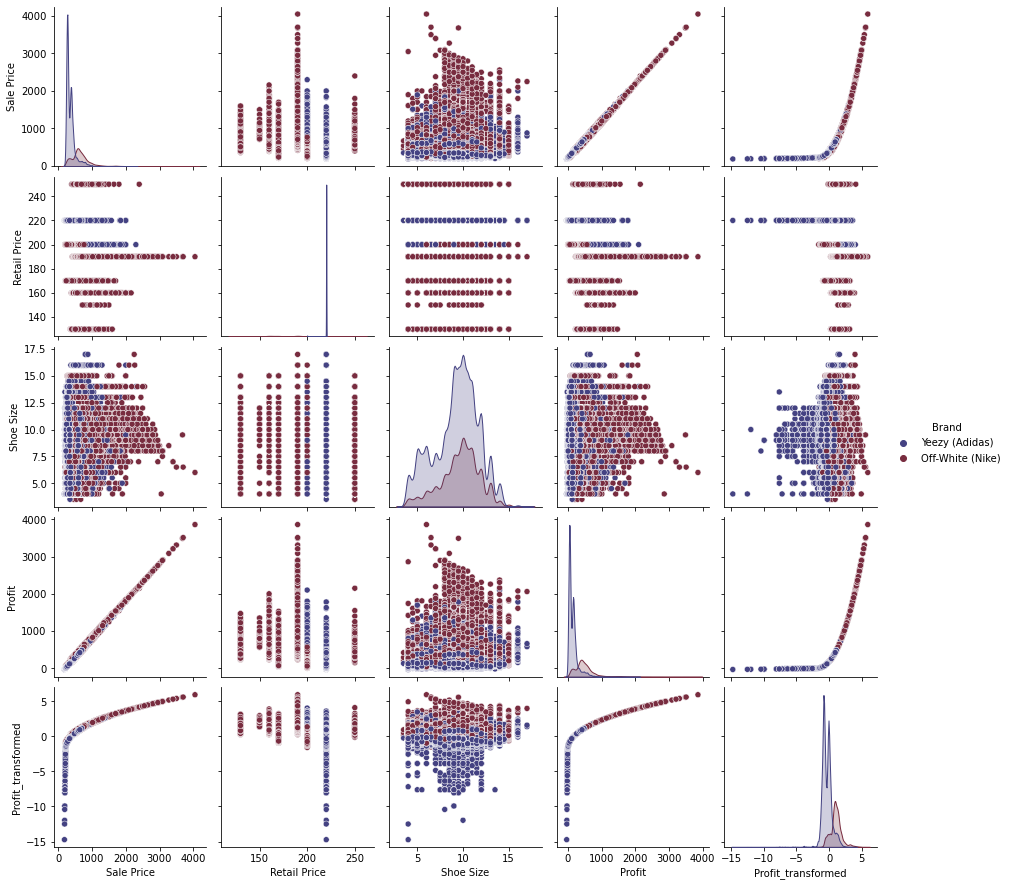

In [22]:
sns.pairplot(stockx_data, diag_kind='kde', hue='Brand', palette='icefire'); 

In [23]:
yeezy = stockx_data[stockx_data['Brand']=='Yeezy (Adidas)']
offwhite = stockx_data[stockx_data['Brand']=='Off-White (Nike)']

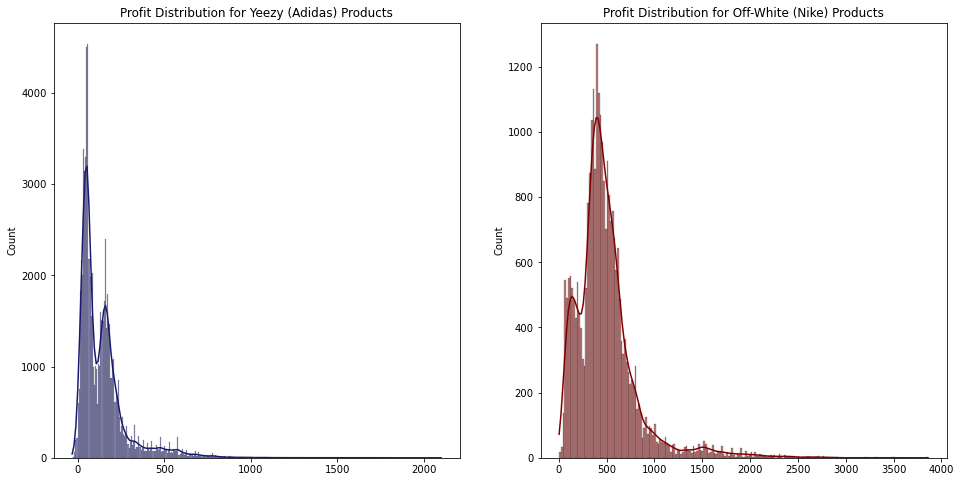

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Profit'].values, kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Profit'].values, kde=True, color='maroon', ax=ax2)

ax1.set_title('Profit Distribution for Yeezy (Adidas) Products')
ax2.set_title('Profit Distribution for Off-White (Nike) Products')

plt.show()

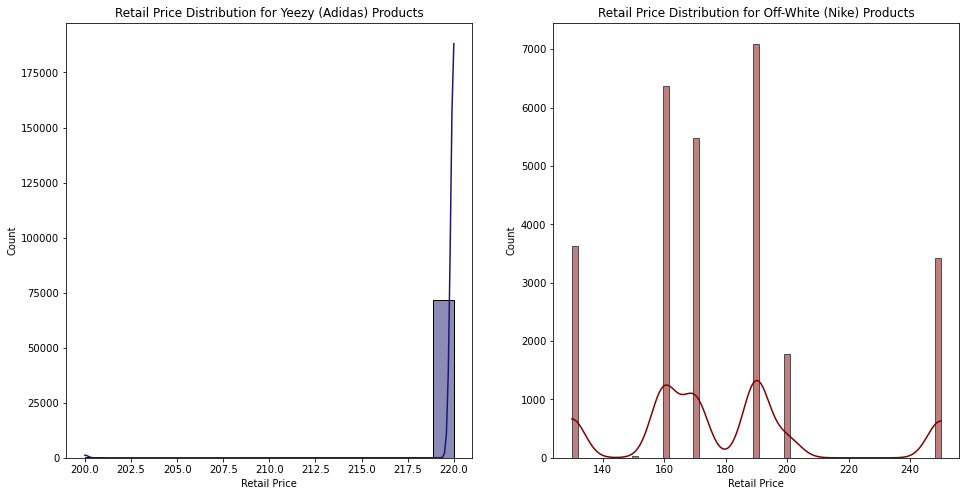

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Retail Price'], kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Retail Price'], kde=True, color='maroon', ax=ax2)

ax1.set_title('Retail Price Distribution for Yeezy (Adidas) Products')
ax2.set_title('Retail Price Distribution for Off-White (Nike) Products')

plt.show()

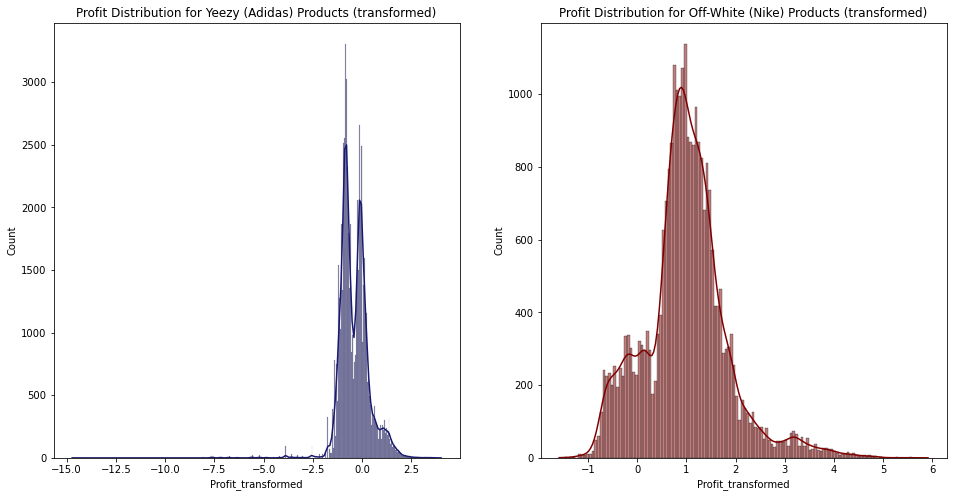

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

ax1 = sns.histplot(yeezy['Profit_transformed'], kde=True, color='midnightblue', ax=ax1)
ax2 = sns.histplot(offwhite['Profit_transformed'], kde=True, color='maroon', ax=ax2)

ax1.set_title('Profit Distribution for Yeezy (Adidas) Products (transformed)')
ax2.set_title('Profit Distribution for Off-White (Nike) Products (transformed)')

plt.show()

In [27]:
yeezy['Profit'].mean(), offwhite['Profit'].mean()

(140.1586569108395, 492.10300784341945)

In [28]:
yeezy['Profit_transformed'].mean(), offwhite['Profit_transformed'].mean()

(-0.38276407808113, 0.9937764050690966)

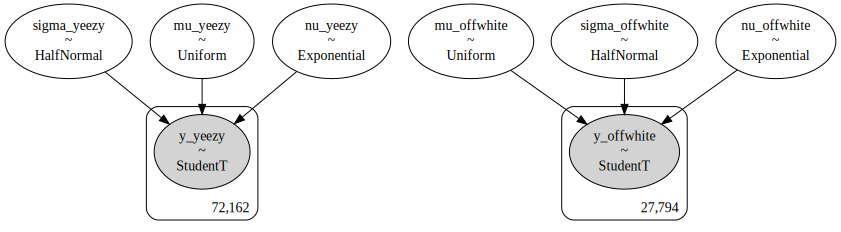

In [30]:
with pm.Model() as model:
    mu_offwhite = pm.Uniform('mu_offwhite', 0, 1000)
    sigma_offwhite = pm.HalfNormal('sigma_offwhite', sd=10)
    nu_offwhite = pm.Exponential('nu_offwhite', 1/30)
    y_offwhite = pm.StudentT('y_offwhite', mu=mu_offwhite, sd=sigma_offwhite, nu=nu_offwhite,
                             observed=offwhite['Profit'])

    mu_yeezy = pm.Uniform('mu_yeezy', 0, 500)
    sigma_yeezy = pm.HalfNormal('sigma_yeezy', sd=10)
    nu_yeezy = pm.Exponential('nu_yeezy', 1/30)
    y_yeezy = pm.StudentT('y_yeezy', mu=mu_yeezy, sd=sigma_yeezy, nu=nu_yeezy,
                        observed=yeezy['Profit'])
    
pm.model_to_graphviz(model)

In [32]:
with model:
    trace = pm.sample(10000, tune=2000, target_accept=.9, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_yeezy, sigma_yeezy, mu_yeezy, nu_offwhite, sigma_offwhite, mu_offwhite]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 583 seconds.


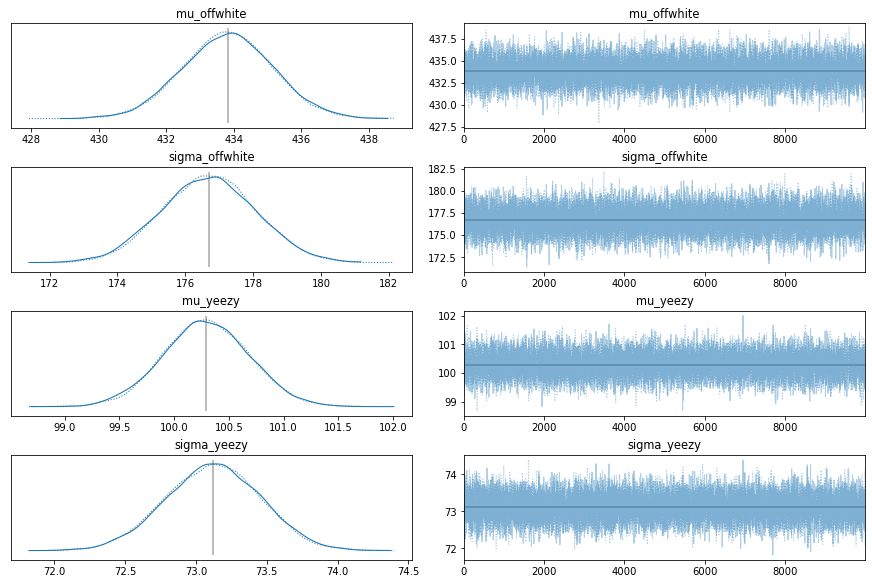

In [35]:
var_names = ['mu_offwhite', 'sigma_offwhite', 'mu_yeezy', 'sigma_yeezy']
lines = list(xarray_var_iter(trace.posterior[var_names].mean(dim=("chain", "draw"))))
az.plot_trace(trace, var_names=var_names, lines=lines);

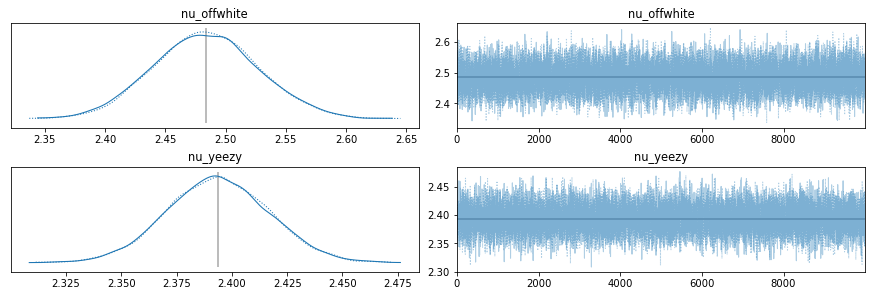

In [36]:
lines = list(xarray_var_iter(trace.posterior[['nu_offwhite', 'nu_yeezy']].mean(dim=("chain", "draw"))))
az.plot_trace(trace, var_names=['nu_offwhite', 'nu_yeezy'], lines=lines);

In [37]:
with model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    idata_prior = az.from_pymc3(prior=prior_checks)

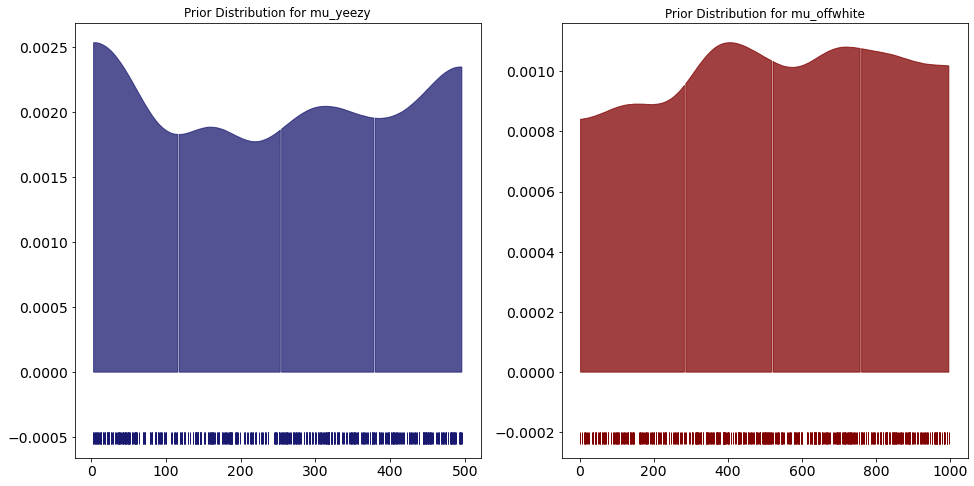

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1 = az.plot_dist(idata_prior.prior['mu_yeezy'], kind='kde', rug=True, 
                   quantiles=[.25, .5, .75], color='midnightblue', ax=ax1)
ax2 = az.plot_dist(idata_prior.prior['mu_offwhite'], kind='kde', rug=True,
                   quantiles=[.25, .5, .75], color='maroon', ax=ax2)

ax1.set_title('Prior Distribution for mu_yeezy')
ax2.set_title('Prior Distribution for mu_offwhite')

plt.show()

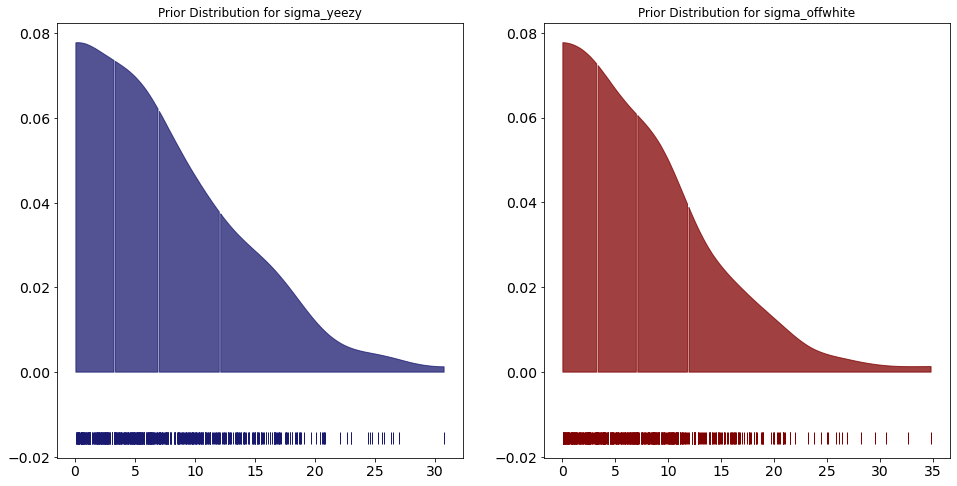

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1 = az.plot_dist(idata_prior.prior['sigma_yeezy'], kind='kde', rug=True, 
                   quantiles=[.25, .5, .75], color='midnightblue', ax=ax1)
ax2 = az.plot_dist(idata_prior.prior['sigma_offwhite'], kind='kde', rug=True,
                   quantiles=[.25, .5, .75], color='maroon', ax=ax2)

ax1.set_title('Prior Distribution for sigma_yeezy')
ax2.set_title('Prior Distribution for sigma_offwhite')

plt.show()

In [40]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_offwhite,433.821,1.336,431.272,436.302,0.009,0.006,21252.0,15719.0,1.0
sigma_offwhite,176.686,1.390,174.002,179.197,0.011,0.008,17093.0,15030.0,1.0
nu_offwhite,2.484,0.043,2.405,2.568,0.000,0.000,17794.0,15742.0,1.0
mu_yeezy,100.293,0.392,99.575,101.045,0.003,0.002,18437.0,15048.0,1.0
sigma_yeezy,73.122,0.334,72.488,73.738,0.003,0.002,16884.0,15842.0,1.0
nu_yeezy,2.394,0.023,2.350,2.437,0.000,0.000,17083.0,15720.0,1.0


In [41]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=var_names+['y_offwhite', 'y_yeezy'], random_seed=RANDOM_SEED)


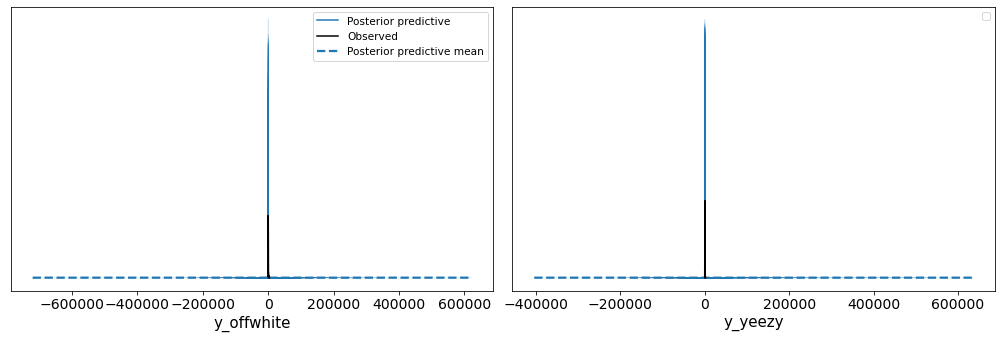

In [42]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

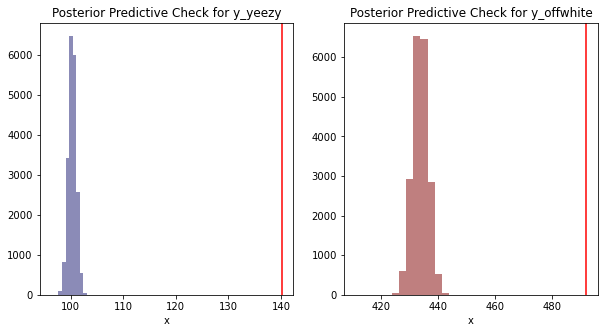

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10, 5))
ax1.hist([y.mean() for y in ppc['y_yeezy']], bins=19, alpha=0.5, color='midnightblue')
ax2.hist([y.mean() for y in ppc['y_offwhite']], bins=19, alpha=0.5, color='maroon')
ax1.axvline(yeezy['Profit'].mean(), color='r')
ax2.axvline(offwhite['Profit'].mean(), color='r')
for ax in [ax1, ax2]:
    ax.set(xlabel='x', ylabel='')
ax1.set_title('Posterior Predictive Check for y_yeezy')
ax2.set_title('Posterior Predictive Check for y_offwhite');

In [44]:
yeezy['Profit'].std()

144.34873247959385

In [45]:
with model:
    diff_means = pm.Deterministic('means difference', mu_yeezy-mu_offwhite)
    diff_std = pm.Deterministic('stds difference', sigma_yeezy-sigma_offwhite)
    effect_size = pm.Deterministic('effect size (cohens d)', diff_means/np.sqrt((yeezy['Profit'].std() ** 2 + offwhite['Profit'].std() ** 2) / 2))
    

In [46]:
with model:
    trace = pm.sample(5000, return_inferencedata=True, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_yeezy, sigma_yeezy, mu_yeezy, nu_offwhite, sigma_offwhite, mu_offwhite]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 265 seconds.


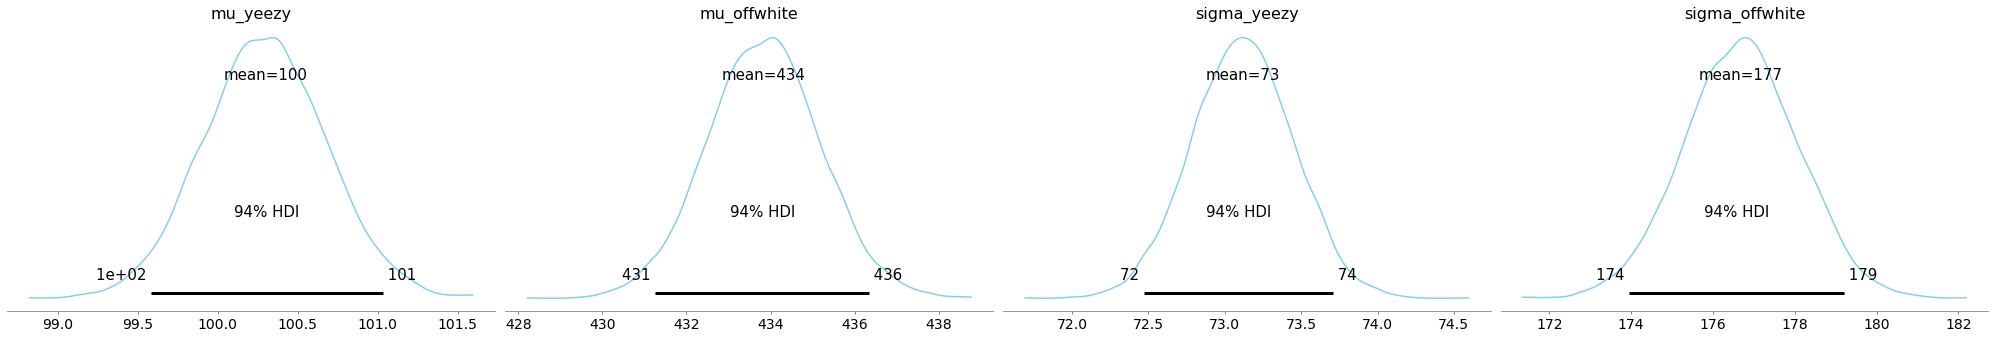

In [47]:
pm.plot_posterior(trace, var_names=['mu_yeezy', 'mu_offwhite', 'sigma_yeezy', 'sigma_offwhite'], color='#87ceeb');

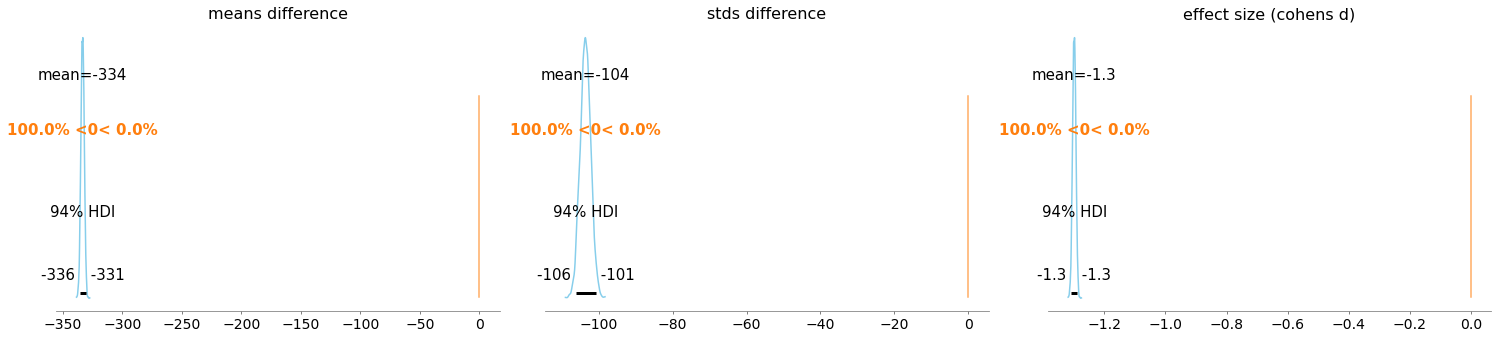

In [48]:
pm.plot_posterior(trace, var_names=['means difference', 'stds difference', 'effect size (cohens d)'], ref_val=0, color='#87ceeb');

In [49]:
az.summary(trace, var_names=['means difference', 'stds difference', 'effect size (cohens d)'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means difference,-333.550,1.400,-336.081,-330.855,0.014,0.010,9435.0,7913.0,1.0
stds difference,-103.559,1.435,-106.170,-100.829,0.016,0.011,8425.0,8127.0,1.0
effect size (cohens d),-1.298,0.005,-1.308,-1.288,0.000,0.000,9435.0,7913.0,1.0
